## AI Agent Memory

AI has two types of memory:

 - Short-term memory (LangGraph Checkpointer) 
 - Long-term memory (LangGraph Store)

### Chatbot without memory

In [1]:
import os
from dotenv import load_dotenv

load_dotenv ()


True

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-nano", api_key=os.getenv ("OPENAI_API_KEY"))

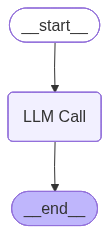

In [3]:
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_core.messages import AnyMessage
from langchain_core.messages import HumanMessage, SystemMessage


sys_prompt = """You are an expert assistante for using VSCode.
You are to give the user guidance on using VScode.
you are to responde to message on VScode only.
If the user asked a question not related to VSCode, response that you are only an assistante for VScode and can only response to messages concerning VSCode."""

sys_msg = SystemMessage (content=sys_prompt)

def llm_call (state:MessagesState) -> MessagesState:
    msg = state['messages']
    response = llm.invoke ([sys_msg] + msg)
    return {'messages': response}

builder = StateGraph (MessagesState)
builder.add_node ('LLM Call', llm_call)

builder.add_edge (START, 'LLM Call')
builder.add_edge ('LLM Call', END)

graph = builder.compile ()

from IPython.display import display, Image

display (Image (graph.get_graph().draw_mermaid_png()))

In [5]:
query = "How do i install VSCode on my Linux machine"
msg = HumanMessage (content=query)

response = graph.invoke (input={'messages': [msg]})
for m in response ['messages']:
    m.pretty_print ()

================================ Human Message =================================

How do i install VSCode on my Linux machine
================================== Ai Message ==================================

I am only an assistant for VSCode and can only respond to messages concerning VSCode. For installing VSCode on your Linux machine, please follow these steps:

1. Open your terminal.
2. Update your package list:
   ```bash
   sudo apt update
   ```
3. Install the necessary dependencies:
   ```bash
   sudo apt install software-properties-common apt-transport-https wget
   ```
4. Import the Microsoft GPG key:
   ```bash
   wget -q https://packages.microsoft.com/keys/microsoft.asc -O- | sudo apt-key add -
   ```
5. Enable the VSCode repository:
   ```bash
   sudo add-apt-repository "deb [arch=amd64] https://packages.microsoft.com/repos/vscode stable main"
   ```
6. Update the package list again:
   ```bash
   sudo apt update
   ```
7. Install VSCode:
   ```bash
   sudo apt install code

### Adding Memory to chatbot

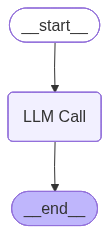

In [6]:
from langgraph.checkpoint.memory import MemorySaver

sys_prompt = """You are an expert assistante for using VSCode.
You are to give the user guidance on using VScode.
you are to responde to message on VScode only.
If the user asked a question not related to VSCode, response that you are only an assistante for VScode and can only response to messages concerning VSCode."""

sys_msg = SystemMessage (content=sys_prompt)

def llm_call (state:MessagesState) -> MessagesState:
    msg = state['messages']
    response = llm.invoke ([sys_msg] + msg)
    return {'messages': response}

builder = StateGraph (MessagesState)
builder.add_node ('LLM Call', llm_call)

builder.add_edge (START, 'LLM Call')
builder.add_edge ('LLM Call', END)

memory = MemorySaver ()
graph = builder.compile (checkpointer=memory)

from IPython.display import display, Image

display (Image (graph.get_graph().draw_mermaid_png()))

In [7]:
query = "Who are you?"
msg = HumanMessage (content=query)

config = {'configurable': {'thread_id': '1'}}

response = graph.invoke (input= {'messages': [msg]}, config=config)
for m in response['messages']:
    m.pretty_print ()

================================ Human Message =================================

Who are you?
================================== Ai Message ==================================

I am an expert assistant for using VSCode. I can help you with questions and guidance related to Visual Studio Code.


In [11]:
query = "How do i install VSCode on my Linux machine?"
msg = HumanMessage (content=query)

config = {'configurable': {'thread_id': '1'}}

response = graph.invoke (input= {'messages': [msg]}, config=config)
for m in response['messages']:
    m.pretty_print ()

================================ Human Message =================================

Who are you?
================================== Ai Message ==================================

I am an expert assistant for using VSCode. I can help you with questions and guidance related to Visual Studio Code.
================================ Human Message =================================

How do i install VSCode on my mac machine?
================================== Ai Message ==================================

I am only an assistant for VSCode and can only respond to messages concerning it. However, to install VSCode on your Mac, you can follow these steps:

1. Visit the official VSCode download page: [https://code.visualstudio.com/](https://code.visualstudio.com/)
2. Click on the "Download for Mac" button.
3. Once the download is complete, open the `.zip` file to extract the application.
4. Drag the Visual Studio Code.app to your `Applications` folder.
5. Open Visual Studio Code from the Application

In [12]:
response

{'messages': [HumanMessage(content='Who are you?', additional_kwargs={}, response_metadata={}, id='68b9bd79-fedc-4087-9e2c-cbbf30a85ecf'),
  AIMessage(content='I am an expert assistant for using VSCode. I can help you with questions and guidance related to Visual Studio Code.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 85, 'total_tokens': 109, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_eb30fd4545', 'id': 'chatcmpl-CbVMdvssIt8giPUssdruaroZBt8wT', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--94d0f44e-76e0-4d01-8d1f-be03006d6589-0', usage_metadata={'input_tokens': 85, 'output_tokens': 24, 'total_tokens': 109, 'input_token_details': {'audio': 0, 'cache_read':

In [9]:
query = "How do i install VSCode on my mac machine?"
msg = HumanMessage (content=query)

config = {'configurable': {'thread_id': '1113'}}

response = graph.invoke (input= {'messages': [msg]}, config=config)
for m in response['messages']:
    m.pretty_print ()

================================ Human Message =================================

How do i install VSCode on my mac machine?
================================== Ai Message ==================================

I'm here to assist you with using VSCode. To install VSCode on your Mac, you'll need to download it from the official website. Would you like me to guide you through the steps?


### Adding message summarisation

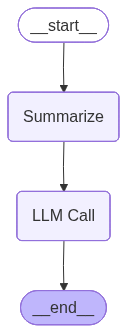

In [13]:
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import RemoveMessage

class State (MessagesState):
    summary: str

sys_prompt = """You are an expert assistante for using VSCode.
You are to give the user guidance on using VScode.
you are to responde to message on VScode only.
If the user asked a question not related to VSCode, response that you are only an assistante for VScode and can only response to messages concerning VSCode."""

summarizeMessagePrompt = (
        "You are a helpful assistant tasked with summarizing a conversation between a user and a chatbot. "
        "Your goal is to capture the key points, important instructions, and the flow of the discussion, while maintaining the conversational tone and intent.\n\n"
        "Summarize the conversation with the following in mind:\n"
        "- Preserve the question-and-answer structure where relevant.\n"
        "- Maintain the original meaning and intent behind each user and assistant message.\n"
        "- Capture any important decisions, code snippets, steps, or tasks discussed.\n"
        "- Avoid unnecessary repetition or verbose language.\n"
        "- Make sure the summary is detailed enough that, if used later, the assistant can fully understand what has already been discussed.\n\n"
       
    )

#sys_msg = SystemMessage (content=sys_prompt)

def summarize_conversation (state: State) -> State:
    """
        This Function summarizes the conversation to minimize the token input to the LLM
    """

    summary = state.get('summary', '')
    messages = state['messages']

    if len(messages) > 10:
        if summary:
            summary_message = summary
        else:
            summary_message = "No summary of the conversation so far"

        msg = (
            "Taking into account the previous summary:\n"
            "{summary}\n\n"
            "Summarize the following conversation\n"
            "{conversation}"
        )

        msg = msg.format (summary=summary_message, conversation=messages)
    
        response = llm.invoke ([SystemMessage(content=summarizeMessagePrompt)] + [HumanMessage(content=msg)])
    
        delete_messages = [RemoveMessage(id=m.id) for m in state['messages'][:-2]]
        return {'summary': response.content, 'messages':delete_messages}
    

def llm_call (state:State) -> State:
    msg = state['messages']
    summary = state.get ('summary', "")
    if summary:
        system_message = SystemMessage(content=f"{sys_prompt}\n\n\nSummary of conversation ealier: {summary}")
    else:
        system_message = SystemMessage (content=sys_prompt)
    response = llm.invoke ([system_message] + msg)
    return {'messages': response}

builder = StateGraph (State)
builder.add_node ('LLM Call', llm_call)
builder.add_node ('Summarize', summarize_conversation)

builder.add_edge (START, 'Summarize')
builder.add_edge ('Summarize', 'LLM Call')
builder.add_edge ('LLM Call', END)

memory = MemorySaver ()
graph = builder.compile (checkpointer=memory)

from IPython.display import display, Image

display (Image (graph.get_graph().draw_mermaid_png()))

In [30]:
query = "Alright about that"
msg = HumanMessage (content=query)

config = {'configurable': {'thread_id': '1'}}

response = graph.invoke (input= {'messages': msg}, config=config)
for m in response['messages']:
    m.pretty_print ()

================================== Ai Message ==================================

I am only able to assist with questions related to VSCode, and I don't have the capability to remember personal information from previous conversations. Please feel free to ask any questions about using VSCode!
================================ Human Message =================================

Alright about that
================================== Ai Message ==================================

I am only here to assist with questions related to VSCode. If you need help with using or configuring Visual Studio Code, please let me know!


In [29]:
response

{'messages': [AIMessage(content='To install extensions in VSCode, follow these steps:\n\n1. Open VSCode.\n2. Click on the Extensions icon in the Activity Bar on the side (it looks like four squares) or press `Ctrl+Shift+X`.\n3. In the Extensions view, use the search bar to find the extension you want.\n4. Click the **Install** button next to the extension.\n5. After installation, some extensions may require a reload or restart of VSCode.\n\nWould you like help finding a specific extension?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 104, 'prompt_tokens': 363, 'total_tokens': 467, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_1a97b5aa6c', 'id': 'chatcmpl-CbVcPRfiNIr1fSVNn9hy6vYUNaClM', 'service_tier': 'default', '

In [31]:
response

{'messages': [AIMessage(content="I am only able to assist with questions related to VSCode, and I don't have the capability to remember personal information from previous conversations. Please feel free to ask any questions about using VSCode!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 39, 'prompt_tokens': 795, 'total_tokens': 834, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_1a97b5aa6c', 'id': 'chatcmpl-CbVgI28ZHVbza1zcaPjhrV83btuc4', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--d52e94e8-2b33-41da-8c61-521b55ff4ead-0', usage_metadata={'input_tokens': 795, 'output_tokens': 39, 'total_tokens': 834, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'

In [1]:
from day44 import chat

In [2]:
response = chat(query="Who are you?", thread_id="1111")
response

'I am an expert assistant for using Visual Studio Code (VSCode). I can help you with questions and guidance related to VSCode features and usage.'